# The CNS North Korea Missile Test Database

In [127]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [128]:
import pandas as pd
import geopandas as gpd
import altair as alt
import altair_stiles as altstiles
import numpy as np
import us
import urllib.request, json
import glob
import os
import requests
from bs4 import BeautifulSoup
import os
import time
import matplotlib.pyplot as plt
import squarify
from matplotlib.pyplot import figure

In [129]:
alt.themes.register("stiles", altstiles.theme)
alt.themes.enable("grid")
figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [130]:
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

---

## Read data

#### Get [list](https://missilethreat.csis.org/country/dprk/) of North Korean missiles from CSIS

In [131]:
my_headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OSX 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko)Chrome/71.0.3578.98 Safari/537.36",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8",
}

In [132]:
missiles_url = "https://missilethreat.csis.org/country/dprk"
page = requests.get(missiles_url, headers=my_headers).content

In [133]:
missile_df = pd.read_html(page)[0].rename(
    columns={
        "Missile Name": "name",
        "Class": "class",
        "Range": "range",
        "Status": "status",
    }
)

In [134]:
missile_df["max_range_km"] = (
    missile_df["range"]
    .str.split(" - ")
    .str[-1]
    .str.replace(" km", "")
    .str.replace(",", "", regex=False)
    .str.replace("+", "", regex=False)
)

In [137]:
missile_df["class"].value_counts

<bound method IndexOpsMixin.value_counts of 0          IRBM
1          IRBM
2          ICBM
3          ICBM
4          ICBM
5          SRBM
6          SRBM
7          MRBM
8          MRBM
9          ASCM
10         SRBM
11          SAM
12         MLRS
13         SRBM
14         SRBM
15         SRBM
16         SRBM
17    Artillery
18         ASCM
19         MLRS
20         SLBM
21         MRBM
22         SLBM
23         IRBM
24          SLV
Name: class, dtype: object>

In [152]:
missile_df["max_range_miles"] = (
    (missile_df["max_range_km"].astype(int) / 1.609).round(0).astype(int)
)

In [156]:
missile_df[
    (missile_df["status"] == "Operational") & (missile_df["class"].str.contains("BM"))
]

In [156]:
missile_df['name'].str.split(' ()')

,name,class,range,status,max_range_km,max_range_miles
3,Hwasong-14,ICBM,"10,400 km",Operational,10400,6464
5,Hwasong-5,SRBM,300 km,Operational,300,186
6,Hwasong-6,SRBM,500 km,Operational,500,311
7,Hwasong 7 (Nodong 1),MRBM,"1,200 - 1,500 km",Operational,1500,932
8,Hwasong-9,MRBM,"800 - 1,000 km",Operational,1000,622
10,KN-02 (Toksa),SRBM,120 - 170 km,Operational,170,106
16,KN-25,SRBM,380 km,Operational,380,236
21,Pukguksong-2 (KN-15),MRBM,"1,200 - 2,000 km",Operational,2000,1243
22,Pukguksong-3 (KN-26),SLBM,"1,900 km",Operational,1900,1181


---

## Launches

#### Download latest version of the Nuclear Threat Initiative database [here](https://beyondparallel.csis.org/database-north-korean-provocations/)

In [68]:
url = "https://www.nti.org/wp-content/uploads/2021/10/north_korea_missile_test_database_current-for-website.xlsx"

In [69]:
resp = requests.get(url)
output = open("data/raw/north_korea_missile_test_database.xls", "wb")
output.write(resp.content)
output.close()

#### Read data

In [70]:
src = pd.read_excel(
    "data/raw/north_korea_missile_test_database.xls", skiprows=1, parse_dates=["Date"]
).sort_values("Date", ascending=False)[
    [
        "Date",
        "Date Entered/Updated",
        "Launch Time (UTC)",
        "Missile Name",
        "Missile Type",
        "Facility Name",
        "Facility Location",
        "Facility Latitude",
        "Facility Longitude",
        "Landing Location",
        "Apogee",
        "Distance Travelled",
        "Confirmation Status",
        "Test Outcome",
        "Additional Information",
        "Source(s)",
    ]
]

In [71]:
src.columns = (
    src.columns.str.lower()
    .str.replace(" ", "_", regex=False)
    .str.replace("/", "_", regex=False)
)

#### Dates

In [72]:
src["year"] = src["date"].dt.year.astype(str)
src["month"] = src["date"].dt.month
src["day"] = src["date"].dt.day
src["day"] = src["date"].dt.day_name()

In [73]:
type_lookup = {
    "SRBM": "Short-range",
    "MRBM": "Medium-range",
    "SLV": "Satellite launch vehicle",
    "SLBM": "Submarine-launched",
    "Unknown": "Unknown",
    "IRBM": "Intermediate-range",
    "ICBM": "Intercontinental",
    "HGV": "Hypersonic glide vehicle",
}

In [74]:
src["missle_type_desc"] = src["missile_type"].map(type_lookup)

In [75]:
df = src[
    (src["missile_name"] != "Unknown") & (src["missile_type"].str.contains("BM"))
].copy()

In [76]:
df["facility_location"] = (
    df["facility_location"].str.replace(", (North Korea)", "", regex=False).str.title()
)

In [77]:
df = df[(df["facility_latitude"] != "Unknown") & (df["test_outcome"] != "Failure")]

In [191]:
df.head(10)

,date,date_entered_updated,launch_time_(utc),missile_name,missile_type,facility_name,facility_location,facility_latitude,facility_longitude,landing_location,apogee,distance_travelled,confirmation_status,test_outcome,additional_information,source(s),year,month,day,missle_type_desc,geometry,decade
202,2022-10-08,2022-10-10,16:53:00,KN-25,SRBM,Munchon,"Munchon, Kangwong Province",39.2815,127.377,Sea of Japan or East Sea,90 km,350 km,Confirmed,Success,2 of 2 tests,https://en.yna.co.kr/view/AEN20221009000354325...,2022,10,Saturday,Short-range,POINT (127.37700 39.28150),2020s
201,2022-10-08,2022-10-10,16:47:00,KN-25,SRBM,Munchon,"Munchon, Kangwong Province",39.2815,127.377,Sea of Japan or East Sea,90 km,350 km,Confirmed,Success,"On October 9 (local time), North Korea launche...",https://en.yna.co.kr/view/AEN20221009000354325...,2022,10,Saturday,Short-range,POINT (127.37700 39.28150),2020s
200,2022-10-05,2022-10-06,21:15:00,KN-23,SRBM,Samsok,"Samsok District, Pyongyang",39.1268,125.9579,Sea of Japan or East Sea,50 km,800 km,Confirmed,Success,2 of 2 tests,https://en.yna.co.kr/view/AEN20221006000853325...,2022,10,Wednesday,Short-range,POINT (125.95790 39.12680),2020s
199,2022-10-05,2022-10-06,21:00:00,KN-25,SRBM,Samsok,"Samsok District, Pyongyang",39.1268,125.9579,Sea of Japan or East Sea,100 km,350 km,Confirmed,Success,"Less than 24 hours after the IRBM launch, Nort...",https://en.yna.co.kr/view/AEN20221006000853325...,2022,10,Wednesday,Short-range,POINT (125.95790 39.12680),2020s
198,2022-10-03,2022-10-06,22:22:00,New IRBM (2022),IRBM,Mupyong-ni Arms Plant,"Mup'Yong-Ni, Chagang Province",40.611208,126.425743,Pacific Ocean,970 km,4500 km,Confirmed,Success,"At 7:22 AM local time on 4 October 2022, North...",https://en.yna.co.kr/view/AEN20221004001354325...,2022,10,Monday,Intermediate-range,POINT (126.42574 40.61121),2020s
197,2022-09-30,2022-10-06,21:58:00,KN-23,SRBM,West Sunan,"Sunan District, Pyongyang",39.3942,125.6773,Sea of Japan or East Sea,50 km,350 km,Confirmed,Success,2 of 2 tests,https://en.yna.co.kr/view/AEN20221001000455325...,2022,9,Friday,Short-range,POINT (125.67730 39.39420),2020s
196,2022-09-30,2022-10-06,21:42:00,KN-23,SRBM,West Sunan,"Sunan District, Pyongyang",39.3942,125.6773,Sea of Japan or East Sea,50 km,400 km,Confirmed,Success,North Korea conducted its 4th missile test in ...,https://en.yna.co.kr/view/AEN20221001000455325...,2022,9,Friday,Short-range,POINT (125.67730 39.39420),2020s
195,2022-09-29,2022-10-06,11:57:00,KN-25,SRBM,Sunchon,North Pyongan Province,39.4163,125.8907,Sea of Japan or East Sea,50 km,300 km,Confirmed,Success,2 of 2 tests,https://en.yna.co.kr/view/AEN20220929010154325...,2022,9,Thursday,Short-range,POINT (125.89070 39.41630),2020s
194,2022-09-29,2022-10-06,11:48:00,KN-25,SRBM,Sunchon,North Pyongan Province,39.4163,125.8907,Sea of Japan or East Sea,50 km,350 km,Confirmed,Success,Hours after the arrival of US Vice President K...,https://en.yna.co.kr/view/AEN20220929010154325...,2022,9,Thursday,Short-range,POINT (125.89070 39.41630),2020s
192,2022-09-28,2022-10-06,09:10:00,Unnamed large solid-propellant SRBM (KN-23 Mod),SRBM,Sunan,"Sunan District, Pyongyang",39.20299,125.70926,Sea of Japan or East Sea,50 km,350 km,Confirmed,Success,"Three days after the previous test, North Kore...",https://en.yna.co.kr/view/AEN20220928009057315...,2022,9,Wednesday,Short-range,POINT (125.70926 39.20299),2020s


In [164]:
df["decade"] = df["year"].str[:3] + "0s"

In [190]:
len(df[df["date"] > "2021-12-30"])

24

#### Create a geodataframe

In [166]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.facility_longitude, df.facility_latitude)
)

In [173]:
launches_grouped = (
    gdf.groupby(
        [
            # "decade",
            "facility_longitude",
            "facility_latitude",
            "facility_name",
            "facility_location",
        ]
    )
    .size()
    .reset_index(name="count")
    .rename(
        columns={"facility_longitude": "longitude", "facility_latitude": "latitude"}
    )
    .sort_values("count", ascending=False)
)

In [174]:
launches_counts_gdf = gpd.GeoDataFrame(
    launches_grouped,
    geometry=gpd.points_from_xy(launches_grouped.longitude, launches_grouped.latitude),
)

In [182]:
launches_counts_gdf

,longitude,latitude,facility_name,facility_location,count,geometry
28,127.536900,39.401670,Hodo Peninsula,Kangwon Province,26,POINT (127.53690 39.40167)
32,127.623600,38.990830,Kittaeryong Missile Base,"Kittae Pass, Kangwon Province",19,POINT (127.62360 38.99083)
11,125.702005,38.686834,Hwangju,"Hwangju, North Hwanghae Province",11,POINT (125.70200 38.68683)
36,129.666664,40.849997,Tonghae Satellite Launching Ground,"Hwadae County, North Hamgyong Province",8,POINT (129.66666 40.85000)
33,127.663750,39.811611,Hungnam,"Hamhung, South Hamgyong",6,POINT (127.66375 39.81161)
15,125.890310,39.412594,Sunchon Airbase,South Pyongan Province,5,POINT (125.89031 39.41259)
9,125.673256,39.200159,Pyongyang International Airport,"Pyongyang, North Korea",5,POINT (125.67326 39.20016)
19,126.425743,40.611208,Mupyong-ni Arms Plant,"Mup'Yong-Ni, Chagang Province",5,POINT (126.42574 40.61121)
26,127.481700,39.167700,Wonsan Kalma International Airport,Kangwon Province,4,POINT (127.48170 39.16770)
35,128.183900,40.036800,Sinpo Shipyard,South Hamgyong Province,4,POINT (128.18390 40.03680)


---

## Aggregate

#### Missiles by year

In [26]:
missile_total = df.groupby(["year"])["date"].count().reset_index(name="count")

In [27]:
missile_total.head()

,year,count
0,1984,3
1,1990,1
2,1991,1
3,1993,4
4,2006,6


#### Fill in missing years 

In [28]:
dummy = pd.read_csv(
    "https://docs.google.com/spreadsheets/d/e/2PACX-1vT1tUkO4UkOeOl5_O_j5yEHplUJF1NLC1u55kCWg_1HsbTputy80dZJubTzCdHCKPmTgMS8V9KS6cmM/pub?gid=687150892&single=true&output=csv",
    dtype={"year": str},
)

In [29]:
missile_total_all = pd.merge(missile_total, dummy, on=["year"], how="right").fillna(0)

In [86]:
missile_total_all.pivot_table(
    index="year", values="count", columns="missle_type_desc"
).reset_index()

In [89]:
missile_by_year = missile_total_all.groupby(["year"])["count"].sum().reset_index()

In [93]:
missile_by_year[missile_by_year["year"] > "1980"].to_csv(
    "data/processed/missile_by_year.csv", index=False
)

In [83]:
bars = (
    alt.Chart(missile_total_all)
    .mark_bar()
    .encode(
        x=alt.X(
            "year:N",
            axis=alt.Axis(
                values=["1960", "1970", "1980", "1990", "2000", "2010", "2022"],
            ),
            title="",
        ),
        y=alt.Y("count:Q", axis=alt.Axis(tickCount=6), title=""),
    )
)

(bars).properties(
    height=300,
    width=650,
    title="North Korea successful ballistic missile launches, by year",
)

alt.Chart(...)

#### Missile types, by year

In [31]:
missile_types_src = (
    df.groupby(["year", "missile_type", "missle_type_desc"])["date"]
    .count()
    .reset_index(name="count")
)

In [32]:
missile_types_src.head()

,year,missile_type,missle_type_desc,count
0,1984,SRBM,Short-range,3
1,1990,SRBM,Short-range,1
2,1991,SRBM,Short-range,1
3,1993,MRBM,Medium-range,1
4,1993,SRBM,Short-range,3


In [33]:
dummy2 = pd.read_csv(
    "https://docs.google.com/spreadsheets/d/e/2PACX-1vT1tUkO4UkOeOl5_O_j5yEHplUJF1NLC1u55kCWg_1HsbTputy80dZJubTzCdHCKPmTgMS8V9KS6cmM/pub?gid=2045819622&single=true&output=csv",
    dtype={"year": str},
)

In [34]:
missile_total_all = pd.merge(
    missile_types_src,
    dummy2,
    on=["year", "missle_type_desc", "missile_type"],
    how="right",
).fillna(0)

In [35]:
missile_total_all.head()

,year,missile_type,missle_type_desc,count
0,1960,IRBM,Intermediate-range,0.0
1,1961,IRBM,Intermediate-range,0.0
2,1962,IRBM,Intermediate-range,0.0
3,1963,IRBM,Intermediate-range,0.0
4,1964,IRBM,Intermediate-range,0.0


In [36]:
missile_treemap = (
    df.groupby(["year", "missile_type", "missle_type_desc"])["date"]
    .count()
    .reset_index(name="count")
).sort_values("missle_type_desc")

In [124]:
thisyear = missile_treemap[missile_treemap["year"] == "2017"]

In [125]:
thisyear

,year,missile_type,missle_type_desc,count
18,2017,ICBM,Intercontinental,3
19,2017,IRBM,Intermediate-range,3
20,2017,MRBM,Medium-range,6
21,2017,SRBM,Short-range,3


In [38]:
otheryears = (
    missile_treemap[missile_treemap["year"] != "2022"]
    .groupby(["missle_type_desc"])["count"]
    .sum()
    .reset_index()
    .sort_values("missle_type_desc")
)

In [39]:
otheryears

,missle_type_desc,count
0,Intercontinental,3
1,Intermediate-range,4
2,Medium-range,21
3,Short-range,89
4,Submarine-launched,5


In [40]:
thisyear

,year,missile_type,missle_type_desc,count
27,2022,ICBM,Intercontinental,1
28,2022,IRBM,Intermediate-range,2
29,2022,MRBM,Medium-range,2
31,2022,SRBM,Short-range,18
30,2022,SLBM,Submarine-launched,1


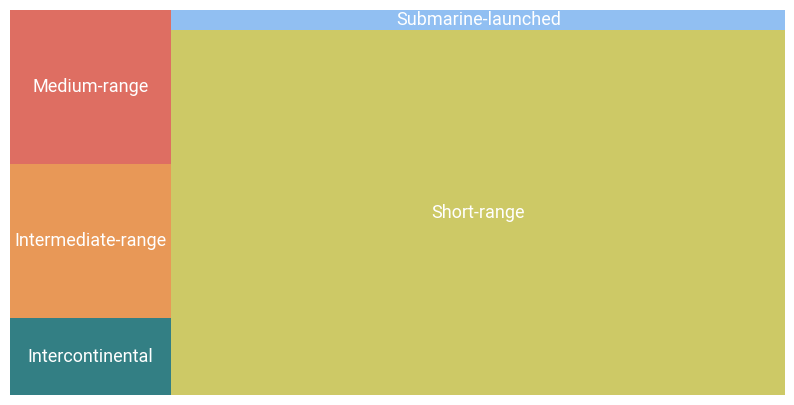

In [94]:
figure(figsize=(10, 5), dpi=100)

squarify.plot(
    sizes=thisyear["count"],
    label=thisyear["missle_type_desc"],
    color=[
        "#005f66",
        "#e37e2d",
        "#d64a3b",
        "#c1bc40",
        "#76b0ef",
    ],
    alpha=0.8,
    text_kwargs={"fontsize": 13, "color": "#ffffff", "fontfamily": "Roboto"},
)
plt.axis("off")
plt.show()

---

In [111]:
circles = (
    alt.Chart(missile_total_all[missile_total_all["year"] > "1979"])
    .mark_circle(opacity=0.6, stroke="#1a1a1a", strokeWidth=0)
    .encode(
        alt.X(
            "year:O",
            axis=alt.Axis(
                values=[
                    "1960",
                    "1970",
                    "1980",
                    "1990",
                    "2000",
                    "2010",
                    "2017",
                    "2018",
                    "2022",
                ],
            ),
            title=" ",
        ),
        alt.Y("missle_type_desc:N", title=" "),
        alt.Size(
            "count:Q",
            title="Missile count",
            scale=alt.Scale(range=[0, 2000]),
            # legend=None,
        ),
        alt.Color("missile_type:N", legend=None),
    )
)

text = (
    alt.Chart(missile_total_all[missile_total_all["year"] == "2022"])
    .mark_text(dx=0, dy=0, color="white")
    .encode(
        x=alt.X("year:O", stack="zero"),
        y=alt.Y("missle_type_desc:O"),
        text=alt.Text("count:Q"),
    )
)

(circles + text).configure_legend(
    symbolType="circle",
    orient="top",
    symbolFillColor="#e6e6e6",
    symbolStrokeColor="#e6e6e6",
).properties(
    width=750,
    height=200,
    title="",
)

In [217]:
circles = (
    alt.Chart(missile_total_all[missile_total_all["year"] >= "2011"])
    .mark_circle(opacity=0.6, stroke="#1a1a1a", strokeWidth=0)
    .encode(
        alt.X(
            "year:O",
            axis=alt.Axis(
                values=[
                    # "1960",
                    # "1970",
                    "1980",
                    "1990",
                    "2000",
                    "2010",
                    "2012",
                    # "2015",
                    # "2018",
                    "2020",
                ],
            ),
            title=" ",
        ),
        alt.Y("missle_type_desc:N", title=" "),
        alt.Size(
            "count:Q",
            title="Missile count",
            scale=alt.Scale(range=[0, 2000]),
            legend=None,
        ),
        alt.Color("missile_type:N", legend=None),
    )
)

# text = (
#     alt.Chart(missile_total_all[missile_total_all["year"] == "2022"])
#     .mark_text(dx=0, dy=0, color="white")
#     .encode(
#         x=alt.X("year:O", stack="zero"),
#         y=alt.Y("missle_type_desc:O"),
#         text=alt.Text("count:Q"),
#     )
# )

(circles).configure_legend(
    symbolType="circle",
    orient="top",
    symbolFillColor="#e6e6e6",
    symbolStrokeColor="#e6e6e6",
).properties(
    width=220,
    height=200,
    title="",
)

alt.Chart(...)

---

## Exports

In [43]:
launches_grouped.to_csv("data/processed/launches_grouped_location.csv", index=False)

In [44]:
launches_counts_gdf.to_file(
    "data/processed/launches_counts_gdf.geojson", driver="GeoJSON"
)

In [45]:
# df = data.la_riots()

df = launches_counts_gdf

# n = alt.topo_feature(
#     "https://gist.githubusercontent.com/irisslee/70039051188dac8f64e14182b5a459a9/raw/2412c45551cff577f7b10604ca523bd3f4dd31d3/countytopo.json",
#     "county",
# )

n = alt.topo_feature(
    "https://gist.githubusercontent.com/stiles/0294dcf54d9ab8bd9eef90af98f40dff/raw/678787a2c6164248df1097984b2debc027e72427/ne_asia.json",
    "ne_asia",
)

In [46]:
df.head()

,decade,longitude,latitude,facility_name,facility_location,count,geometry
22,2010s,127.536900,39.401670,Hodo Peninsula,Kangwon Province,24,POINT (127.53690 39.40167)
3,2000s,127.623600,38.990830,Kittaeryong Missile Base,"Kittae Pass, Kangwon Province",13,POINT (127.62360 38.99083)
12,2010s,125.702005,38.686834,Hwangju,"Hwangju, North Hwanghae Province",11,POINT (125.70200 38.68683)
25,2010s,127.623600,38.990830,Kittaeryong Missile Base,"Kittae Pass, Kangwon Province",6,POINT (127.62360 38.99083)
2,1990s,129.666664,40.849997,Tonghae Satellite Launching Ground,"Hwadae County, North Hamgyong Province",5,POINT (129.66666 40.85000)


In [ ]:
# alt.layer(horse, miles, data=cars).facet(
#     # column='Origin'
#     facet=alt.Facet('Origin', sort=['USA', 'Europe', 'Japan']),
#     columns=2
# )

In [65]:
ne_asia = (
    alt.Chart(n)
    .mark_geoshape(fill="#e9e9e9", stroke="white")
    .properties(width=600, height=600)
    .project("equirectangular")
)

points = (
    alt.Chart()
    .mark_circle()
    .encode(
        longitude="longitude:Q",
        latitude="latitude:Q",
        size=alt.value(10),
    )
)

alt.layer(ne_asia, points, data=df).facet(facet=alt.Facet("decade"))

/Users/stiles/.local/share/virtualenvs/notebooks-sxqKeO4C/lib/python3.8/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.FacetChart(...)

In [79]:
df.to_csv("data/processed/all_missle_launches.csv", index=False)